In [643]:
from dataset import load_split
import networkx as nx
import pandas as pd
import random
import numpy as np

random.seed(10)

In [644]:
df_train = load_split("train")
df_val = load_split("val")
df_test = load_split("test")

In [645]:
print("train:", len(df_train))
print("val:", len(df_val))
print("test:", len(df_test))

train: 5419
val: 677
test: 677


In [646]:
df_test.head()

,head,relation,tail
0,MBNL1-AS1,ceRNA or sponge,miR-135a-5p
1,LINC01503,ceRNA or sponge,FOXK1
2,HOTTIP,expression association,CHI3L1
3,PITPNA-AS1,ceRNA or sponge,c-MET
4,TUG1,expression association,BNIP3


In [706]:
G = nx.from_pandas_edgelist(df_test, source="head", target="tail", edge_attr="relation", create_using=nx.MultiDiGraph())
G_train = nx.from_pandas_edgelist(df_train, source="head", target="tail", edge_attr="relation", create_using=nx.MultiDiGraph())
G_val = nx.from_pandas_edgelist(df_val, source="head", target="tail", edge_attr="relation", create_using=nx.MultiDiGraph())


In [708]:
def corrupted_tail_samples(e, G):
    return [(e[0], n) for n in G.nodes()]  # actually only if n != e[1], but set filters that out later

def corrupted_head_samples(e, G):
    return [(n, e[1]) for n in G.nodes()]

def filter_candidates(candidates, filter_edges):
    return {c for c in candidates if c not in filter_edges}

def score(c):
    return random.random()

def score_by_degree(c):
    left_degree = G_train.degree(c[0]) if c[0] in G_train else 0
    right_degree = G_train.degree(c[1]) if c[1] in G_train else 0
    return left_degree + right_degree

def score_by_edge_count(c):
    in_edges = G_train.in_edges(c[1]) if c[1] in G_train else []
    out_edges = G_train.out_edges(c[0]) if c[0] in G_train else []
    return len(in_edges) + len(out_edges)


def compute_metrics(G, score_fn, k=10, filter_graphs=None):
    if not filter_graphs:
        filter_edges = set(G.edges())
    else:
        filter_edges = set()
        for g in filter_graphs:
            filter_edges |= set(g.edges())
    ranks = []
    reciprocal_ranks = []
    hit_at_k = []
    for e in G.edges():
        candidates = set()
        candidates |= set(corrupted_tail_samples(e, G))
        candidates |= set(corrupted_head_samples(e, G))
        assert len(candidates) == len(G.nodes()) * 2 - 1  # -1 because otherwise the self-edge is counted twice
        filtered_candidates = filter_candidates(candidates, filter_edges)  # TODO Here we want to filter out all true edges from all sets
        filtered_candidates |= {(e[0], e[1])}

        true_edges = {x for x in G.edges() if x[0] == e[0] or x[1] == e[1]}
        assert len(filtered_candidates) == len(candidates) - len(true_edges) + 1

        score_list = [(c, score_fn(c)) for c in filtered_candidates]
        random.shuffle(score_list)
        score_list.sort(key=lambda x: x[1], reverse=True)
        for j, ((n1, n2), _) in enumerate(score_list):
            if (n1, n2) == e:
                ranks.append(j + 1)
                reciprocal_ranks.append(1 / (j + 1))
                hit_at_k.append(j + 1 <= k)
                break
    assert len(ranks) == len(reciprocal_ranks) == len(hit_at_k) == len(G.edges())
    return ranks, reciprocal_ranks, hit_at_k

ranks, reciprocal_ranks, hit_at_k = compute_metrics(G, score, filter_graphs=[G])
print("mean rank:", sum(ranks) / len(ranks))
print("mean reciprocal rank:", sum(reciprocal_ranks) / len(reciprocal_ranks))
print("hit at k:", sum(hit_at_k) / len(hit_at_k))
print('number of hits at k:', sum(hit_at_k))

ranks, reciprocal_ranks, hit_at_k = compute_metrics(G, score_by_degree)
print("mean rank:", sum(ranks) / len(ranks))
print("mean reciprocal rank:", sum(reciprocal_ranks) / len(reciprocal_ranks))
print("hit at k:", sum(hit_at_k) / len(hit_at_k))
print('number of hits at k:', sum(hit_at_k))

ranks, reciprocal_ranks, hit_at_k = compute_metrics(G, score_by_edge_count)
print("mean rank:", sum(ranks) / len(ranks))
print("mean reciprocal rank:", sum(reciprocal_ranks) / len(reciprocal_ranks))
print("hit at k:", sum(hit_at_k) / len(hit_at_k))
print('number of hits at k:', sum(hit_at_k))


mean rank: 817.685376661743
mean reciprocal rank: 0.0036441562563016795
hit at k: 0.0029542097488921715
number of hits at k: 2
mean rank: 548.0502215657311
mean reciprocal rank: 0.003754015035738931
hit at k: 0.0
number of hits at k: 0
mean rank: 418.11669128508123
mean reciprocal rank: 0.006436851746996589
hit at k: 0.0029542097488921715
number of hits at k: 2


In [709]:
m = 10000
n = len(G.edges())
bootstrap_mean_ranks = []
bootstrap_mean_reciprocal_ranks = []
bootstrap_mean_hit_at_k = []
for i in range(m):
    bootstrap_ranks = random.choices(ranks, k=n)
    bootstrap_reciprocal_ranks = random.choices(reciprocal_ranks, k=n)
    bootstrap_hit_at_k = random.choices(hit_at_k, k=n)
    bootstrap_mean_ranks.append(sum(bootstrap_ranks) / len(bootstrap_ranks))
    bootstrap_mean_reciprocal_ranks.append(sum(bootstrap_reciprocal_ranks) / len(bootstrap_reciprocal_ranks))
    bootstrap_mean_hit_at_k.append(sum(bootstrap_hit_at_k))


<Axes: >

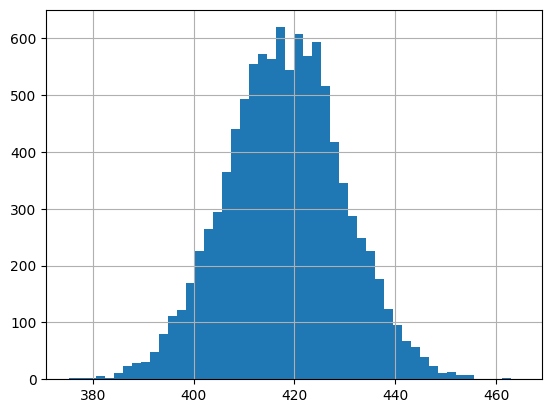

In [710]:

# Plot the distribution of mean ranks
pd.Series(bootstrap_mean_ranks).hist(bins=50)

<Axes: >

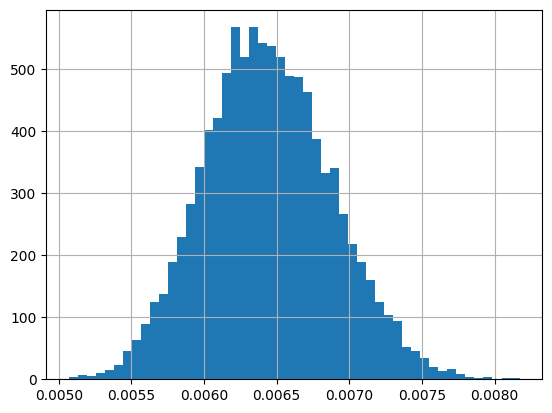

In [711]:

# Plot the distribution of mean reciprocal ranks
pd.Series(bootstrap_mean_reciprocal_ranks).hist(bins=50)

<Axes: >

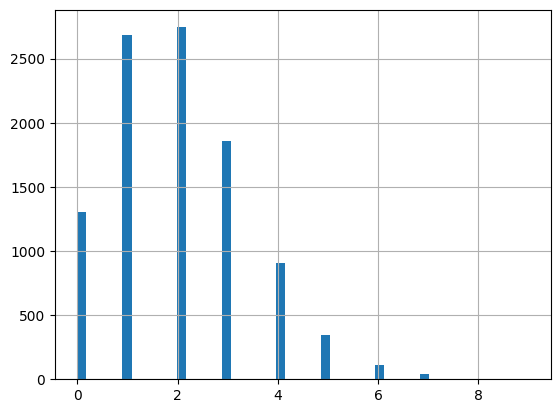

In [712]:

# Plot the distribution of hit at k
pd.Series(bootstrap_mean_hit_at_k).hist(bins=50)